In [1]:
#%matplotlib notebook
#%matplotlib qt
%matplotlib inline

import glob

import logging
logging.getLogger('tensorflow').disabled = True

from spcc import *
from sklearn.gaussian_process import GaussianProcessRegressor
import seaborn as sns
#sns.set_style("darkgrid")
sns.set_style('ticks')

ImportError: No module named pandas

In [ ]:
host_files  = glob.glob("/home/hirmans/Downloads/datasets/DES_BLIND+HOSTZ/*.DAT")
host_answer = '/home/hirmans/Downloads/datasets/DES_UNBLIND_KEY/DES_UNBLIND+HOSTZ.KEY'

In [5]:
obj_info = object_information(host_files)

# Gaussian Process Interpolation

Pending issues:

1. try different kernels
2. add to selection cuts the goodness of the interpolation

In [9]:
snid_list   = list(obj_info.keys())
sample_snid = random.choice(snid_list)
sample_df   = obj_info[sample_snid][3]

sample_tgrid, sample_mean_std = gaussian_process_interpolation(sample_df)
sample_mean_std

f(t_0)     f(t_1)     f(t_2)     f(t_3)     f(t_4)     f(t_5)  \
g       5.499852   9.240700   0.939891  -0.974769  -1.719960   0.911201   
g_err   4.498261   3.457407   5.415059   5.405494   5.343208   5.239101   
i      23.236863  22.664769  22.049211  21.393187  20.699944  19.972954   
i_err   3.439895   3.240520   3.057185   2.889384   2.736370   2.597187   
r      16.546171  16.228230  15.866289  15.462085  15.017676  14.535434   
r_err   1.926952   1.785239   1.659957   1.550976   1.457718   1.379149   
z      12.762069  12.578216  12.381364  12.171903  11.950257  11.716884   
z_err   2.934992   2.808017   2.685378   2.567395   2.454382   2.346646   

          f(t_6)     f(t_7)     f(t_8)     f(t_9)  ...   f(t_40)   f(t_41)  \
g       2.969704   0.452706   0.003837   0.003857  ... -1.992368 -0.981799   
g_err   3.734290   5.400705   5.434107   5.434075  ...  5.018550  5.208442   
i      19.215892  18.432598  17.627056  16.803355  ... -0.080934 -0.121499   
i_err   2.470721   2.355759   2.251070   2.155472  ...  1.703083  1.692003   
r      14.018020  13.468365  12.889645  12.285251  ... -1.417889 -1.412198   
r_err   1.313803   1.259878   1.215376   1.178263  ...  1.100702  1.096958   
z      11.472274  11.216947  10.951451  10.676360  ...  0.985141  0.741664   
z_err   2.244475   2.148139   2.057877   1.973894  ...  1.665998  1.718706   

        f(t_42)   f(t_43)   f(t_44)   f(t_45)   f(t_46)   f(t_47)   f(t_48)  \
g      0.140484  0.015551 -0.005001 -0.447273 -2.187986 -0.608181 -0.975583   
g_err  5.064072  5.431083  5.434097  5.339981  2.293736  5.266538  5.375801   
i     -0.139931 -0.138498 -0.119478 -0.085141 -0.037730  0.020568  0.087632   
i_err  1.691880  1.708267  1.746789  1.812466  1.909040  2.038561  2.201359   
r     -1.384527 -1.337048 -1.271973 -1.191520 -1.097898 -0.993280 -0.879780   
r_err  1.099179  1.111292  1.137478  1.181684  1.247080  1.335650  1.448082   
z      0.507325  0.282318  0.066803 -0.139092 -0.335269 -0.521661 -0.698232   
z_err  1.778142  1.844488  1.917837  1.998200  2.085510  2.179636  2.280383   

        f(t_49)  
g     -3.856582  
g_err  4.416145  
i      0.161431  
i_err  2.396364  
r     -0.759438  
r_err  1.583932  
z     -0.864976  
z_err  2.387513  

[8 rows x 50 columns]

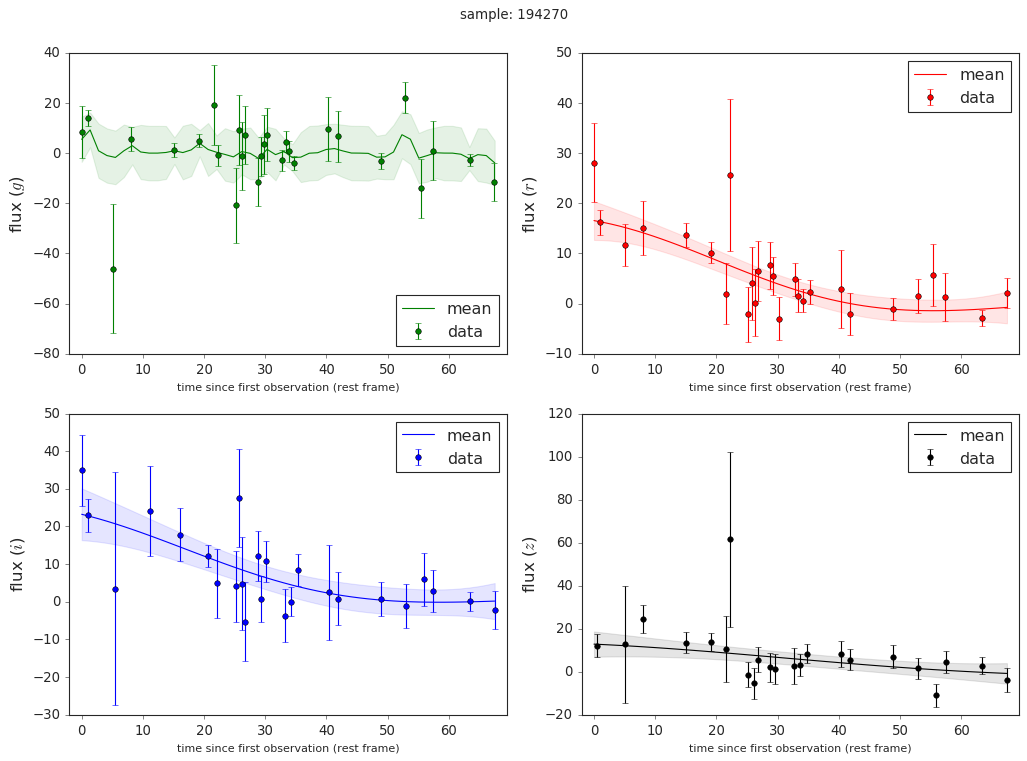

In [10]:
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(13,10))
fig.suptitle('sample: {}'.format(sample_snid))

#lc_passbands = ['g','i','r','z']
sample_groups    = sample_df.groupby('FLT')

for pb in passbands_dict.keys():
    idx       = list(passbands_dict.keys()).index(pb)
    sample_pb = sample_groups.get_group(pb) 

    #data
    axs.flat[idx].errorbar(sample_pb['Tres'].values,sample_pb['FLUXCAL'].values,
                           yerr=sample_pb['FLUXCALERR'].values,
                           color=passbands_dict[pb],
                           linestyle='',marker='o',markersize=5,label='data')
    
    #Gaussian process interpolation
    sample_pb_max = sample_mean_std.loc[pb].values+2.0000*sample_mean_std.loc[pb+'_err'].values
    sample_pb_min = sample_mean_std.loc[pb].values-2.0000*sample_mean_std.loc[pb+'_err'].values
    axs.flat[idx].fill_between(sample_tgrid,sample_pb_max,sample_pb_min,
                               color=passbands_dict[pb],alpha=0.1)
    
    #mean
    sample_mean  = sample_mean_std.loc[pb].values
    axs.flat[idx].plot(sample_tgrid,sample_mean,color=passbands_dict[pb],label='mean')
        
    axs.flat[idx].set_xlabel('time since first observation (rest frame)',fontsize=10)
    axs.flat[idx].set_xlim([sample_tgrid.min()-2,sample_tgrid.max()+2])
    axs.flat[idx].set_ylabel('flux (${}$)'.format(pb),fontsize=15)
    axs.flat[idx].legend(loc='best');   
    
#plt.tight_layout()
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Estimation of $t_0$

Pending issues:
1. Determine in which cases we have a peak within the observation window
2. Determine t0 when there are no peak in the observation window

# Selection cuts

Pending issues:
1. Relax the condition of having observations in the 4 passbands
2. Include the quality of the gaussian process regression to accept/reject a sample

# Training & test sets

## Baseline dataset

1. Selection cuts:
    - light curves with information in 4 passbands
    - light curves with at least 20 observations (~5 observations per band)
    
    
2. Gaussian process interpolation: regular grid of 50 timesteps with kernel
    
    <code> kernel = C(constant_value=1.0,constant_value_bounds=(1e-3, 1e3)) * RBFlength_scale=10,length_scale_bounds=(1e-2, 1e2)) </code>


In [3]:
#creation of the dataset
"""
training_snid,training_array,training_labels,\
test_snid,test_array,test_labels = create_sets(host_files,host_answer,ftrain=0.7)

data_dict = {'training_snid':training_snid,
             'training_array':training_array,
             'training_labels':training_labels,
             'test_snid':test_snid,
             'test_array':test_array,
             'test_labels':test_labels}
np.savez_compressed('baseline_dataset.npz',**data_dict)
"""

#load the results
dict_data = np.load('baseline_dataset.npz')
training_snid   = dict_data['training_snid']
training_array  = dict_data['training_array']
training_labels = dict_data['training_labels']
test_snid   = dict_data['test_snid']
test_array  = dict_data['test_array']
test_labels = dict_data['test_labels']

print('size of spec set after the cuts:',len(training_labels))
print('size of phot set after the cuts:',len(test_labels))

size of spec set after the cuts: 1145
size of phot set after the cuts: 16383


In [6]:
training_sne1a_snid = training_snid[np.where(training_labels==1)]
training_sne1a_z    = []
for snid in training_sne1a_snid:
    #note that we use the spectroscopic redshift when is available
    z = obj_info[snid][2]['REDSHIFT_SPEC'][0]
    training_sne1a_z.append(z)
training_sne1a_z = np.asarray(training_sne1a_z)


training_nonsne1a_snid = training_snid[np.where(training_labels==0)]
training_nonsne1a_z    = []
for snid in training_nonsne1a_snid:
    z = obj_info[snid][2]['REDSHIFT_SPEC'][0]
    training_nonsne1a_z.append(z)
training_nonsne1a_z =  np.asarray(training_nonsne1a_z)


test_sne1a_snid = test_snid[np.where(test_labels==1)]
test_sne1a_z    = []
for snid in test_sne1a_snid:
    #in the photometric sample we have only the host galaxy redshift
    z = obj_info[snid][2]['HOST_GALAXY_PHOTO-Z'][0]
    test_sne1a_z.append(z)
test_sne1a_z = np.asarray(test_sne1a_z)


test_nonsne1a_snid = test_snid[np.where(test_labels==0)]
test_nonsne1a_z    = []
for snid in test_nonsne1a_snid:
    z = obj_info[snid][2]['HOST_GALAXY_PHOTO-Z'][0]
    test_nonsne1a_z.append(z)
test_nonsne1a_z =  np.asarray(test_nonsne1a_z)

### Prior distributions

In [16]:
fraction_spec     = float(np.sum(training_labels))/len(training_labels)
fraction_non_spec = float(np.sum(test_labels))/len(test_labels)
print('fraction of SNeIa in spec files    : {:.3f}'.format(fraction_spec))
print('fraction of SNeIa in phot files    : {:.3f}'.format(fraction_non_spec))

fraction of SNeIa in spec files    : 0.711
fraction of SNeIa in phot files    : 0.259


Therefore, the prior probabilities are:
1. Spectroscopic sample: 
$$P_{spec}(y=0)=0.289\hspace{1cm}P_{spec}(y=1)=0.711$$ 
2. Photometric sample:
$$P_{phot}(y=0)=0.741\hspace{1cm}P_{phot}(y=1)=0.259$$

### Data distributions P(z)

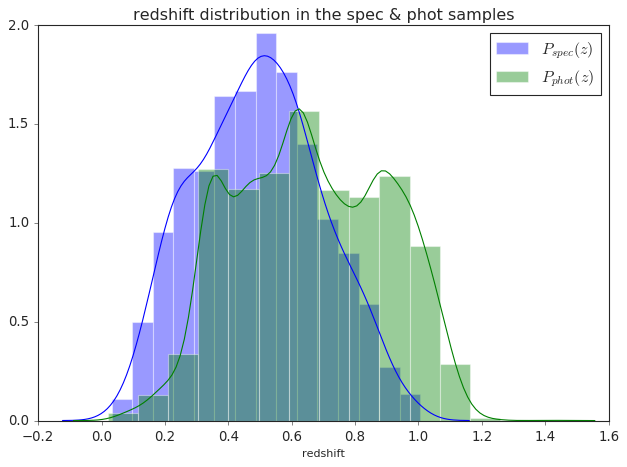

In [22]:
training_z = np.concatenate((training_sne1a_z,training_nonsne1a_z),axis=0)
test_z     = np.concatenate((test_sne1a_z,test_nonsne1a_z),axis=0)

fig, ax = plt.subplots()    

ax.set_title('redshift distribution in the spec & phot samples')
sns.distplot(training_z,ax=ax,bins=15,kde=True,color='blue',label='$P_{spec}(z)$')
sns.distplot(test_z,norm_hist=True,ax=ax,bins=15,kde=True,color='green',label='$P_{phot}(z)$')
ax.set_xlabel('redshift',fontsize=10)
ax.legend(loc='best') 

plt.tight_layout()
plt.savefig('baseline_dataset_data_distributions.pdf')

Data distributions are slightly different. However, the photometric sample extends to a larger redshift.

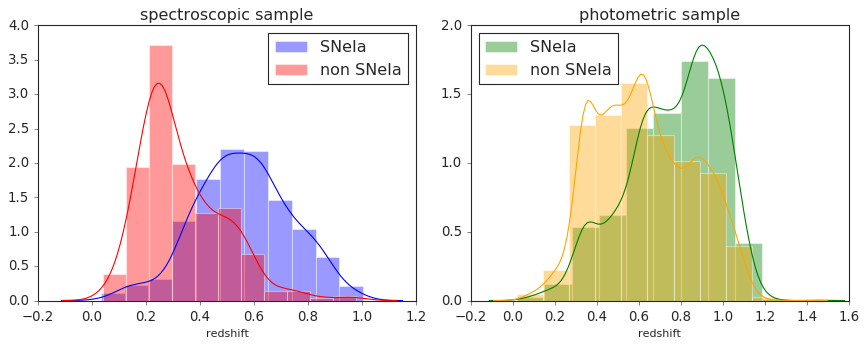

In [24]:
#plotting
fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(11,4.5))

axs.flat[0].set_title('spectroscopic sample')
sns.distplot(training_sne1a_z,ax=axs.flat[0],bins=11,kde=True,color='blue',label='SNeIa')
sns.distplot(training_nonsne1a_z,ax=axs.flat[0],bins=11,kde=True,color='red',label='non SNeIa')
axs.flat[0].set_xlabel('redshift',fontsize=10)
axs.flat[0].legend(loc='best') 

axs.flat[1].set_title('photometric sample')
sns.distplot(test_sne1a_z,norm_hist=True,ax=axs.flat[1],bins=11,kde=True,color='green',label='SNeIa')
sns.distplot(test_nonsne1a_z,norm_hist=True,ax=axs.flat[1],bins=11,kde=True,color='orange',label='non SNeIa')
axs.flat[1].set_xlabel('redshift',fontsize=10)
axs.flat[1].legend(loc='best') 

plt.tight_layout()
plt.savefig('baseline_dataset_samples.pdf')

SNeIa extends to a larger redshift than non-SNeIa both in the spectroscopic and the photometric sample.

### Conditional distributions P(z|y)

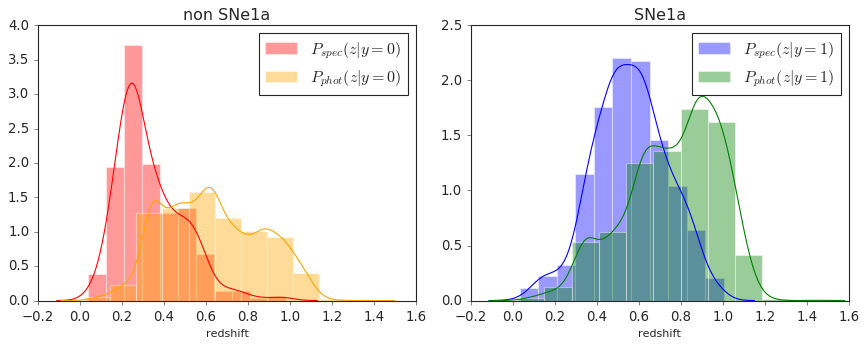

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,4.5))    

axs.flat[0].set_title('non SNe1a')
sns.distplot(training_nonsne1a_z,ax=axs.flat[0],bins=11,kde=True,color='red',label='$P_{spec}(z|y=0)$')
sns.distplot(test_nonsne1a_z,norm_hist=True,ax=axs.flat[0],bins=11,kde=True,color='orange',label='$P_{phot}(z|y=0)$')
axs.flat[0].set_xlabel('redshift',fontsize=10)
axs.flat[0].legend(loc='best') 


axs.flat[1].set_title('SNe1a')
sns.distplot(training_sne1a_z,ax=axs.flat[1],bins=11,kde=True,color='blue',label='$P_{spec}(z|y=1)$')
sns.distplot(test_sne1a_z,norm_hist=True,ax=axs.flat[1],bins=11,kde=True,color='green',label='$P_{phot}(z|y=1)$')
axs.flat[1].set_xlabel('redshift',fontsize=10)
axs.flat[1].legend(loc='best') 

plt.tight_layout()
plt.savefig('baseline_dataset_conditional_distributions.pdf')

The photometric sample extends to a larger redshift than the spectroscopic sample both for SNeIa and non-SNeIa. 